# Kaggle NLP Disaster Tweets Mini Project
* Problem & Data Description

* Exploratory Data Analysis (EDA)

* Preprocessing & Tokenization

* Model Architecture & Rationale

* Training Strategy & Callbacks

* Results & Analysis

* Conclusion & Next Steps

* Submission

### **Imports**

In [15]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


### **Load and Inspect Data**

In [16]:
TRAIN_PATH = "/kaggle/input/nlp-getting-started/train.csv"
TEST_PATH = "/kaggle/input/nlp-getting-started/test.csv"

df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (7613, 5)
Test shape: (3263, 4)


In [17]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### **Exploratory Data Analysis (EDA)**

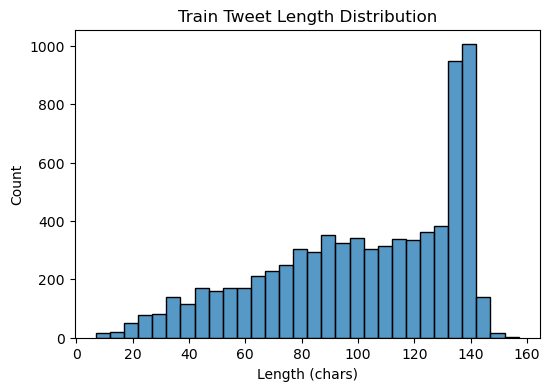

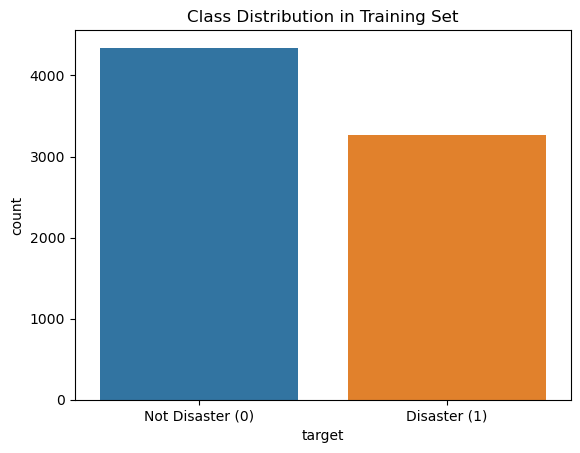

In [19]:
df_train['length'] = df_train['text'].str.len()
df_test['length'] = df_test['text'].str.len()

plt.figure(figsize=(6,4))
sns.histplot(df_train['length'], bins=30)
plt.title("Train Tweet Length Distribution")
plt.xlabel("Length (chars)")
plt.show()

g = sns.countplot(x='target', data=df_train)
g.set_xticklabels(['Not Disaster (0)', 'Disaster (1)'])
plt.title("Class Distribution in Training Set")
plt.show()

If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

### **Data Cleaning / Preprocessing Functions**

In [20]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z0-9 ]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning
df_train['clean_text'] = df_train['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

X = df_train['clean_text']
y = df_train['target']
X_test = df_test['clean_text']

### **Tokenization and Sequencing**

In [21]:
MAX_VOCAB = 10000
MAX_LEN = 100
EMBED_DIM = 128

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

seq_train = tokenizer.texts_to_sequences(X)
seq_test = tokenizer.texts_to_sequences(X_test)

x_train_pad = pad_sequences(seq_train, maxlen=MAX_LEN, padding='post', truncating='post')
x_test_pad  = pad_sequences(seq_test, maxlen=MAX_LEN, padding='post', truncating='post')

X_train, X_val, y_train, y_val = train_test_split(
    x_train_pad, y, test_size=0.2, random_state=42, stratify=y
)

### **Build tf.data Pipelines**

In [22]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(10000).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

### **Handling Class Imbalance**

In [23]:
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

Class weights: {0: 0.8767636049524906, 1: 1.1635460450897974}


### **Model Architecture**

In [24]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=EMBED_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                      

### **Compile and Add Callbacks**

In [25]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_auc', mode='max')
]

### **Train the Model**

In [26]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
191/191 [==============================] - 23s 96ms/step - loss: 0.5742 - accuracy: 0.6934 - auc: 0.7671 - val_loss: 0.4520 - val_accuracy: 0.7925 - val_auc: 0.8570 - lr: 0.0010
Epoch 2/10
191/191 [==============================] - 18s 92ms/step - loss: 0.3640 - accuracy: 0.8529 - auc: 0.9134 - val_loss: 0.4608 - val_accuracy: 0.8070 - val_auc: 0.8571 - lr: 0.0010
Epoch 3/10
191/191 [==============================] - ETA: 0s - loss: 0.2545 - accuracy: 0.9048 - auc: 0.9576
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
191/191 [==============================] - 17s 88ms/step - loss: 0.2545 - accuracy: 0.9048 - auc: 0.9576 - val_loss: 0.5486 - val_accuracy: 0.7925 - val_auc: 0.8450 - lr: 0.0010
Epoch 4/10
191/191 [==============================] - 17s 91ms/step - loss: 0.1630 - accuracy: 0.9460 - auc: 0.9819 - val_loss: 0.8304 - val_accuracy: 0.7597 - val_auc: 0.8283 - lr: 5.0000e-04
Epoch 5/10
191/191 [==============================] - ETA: 0s - l

### **Results and Evaluation**

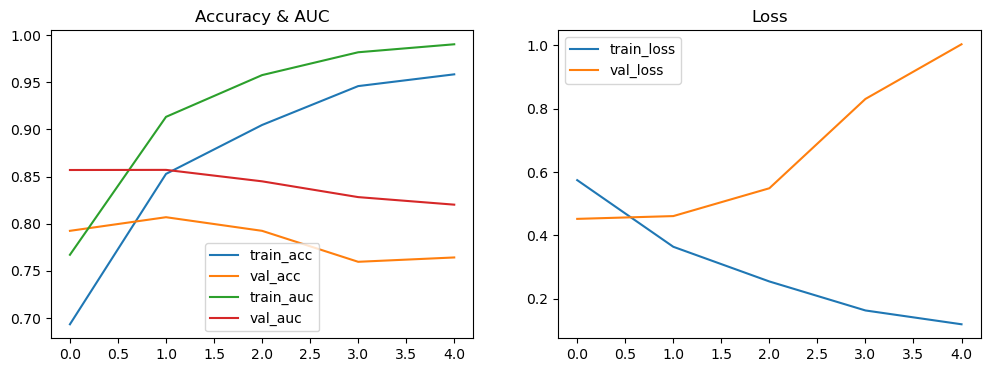

48/48 [==============================] - 2s 21ms/step
              precision    recall  f1-score   support

Not Disaster       0.78      0.92      0.84       869
    Disaster       0.86      0.66      0.75       654

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



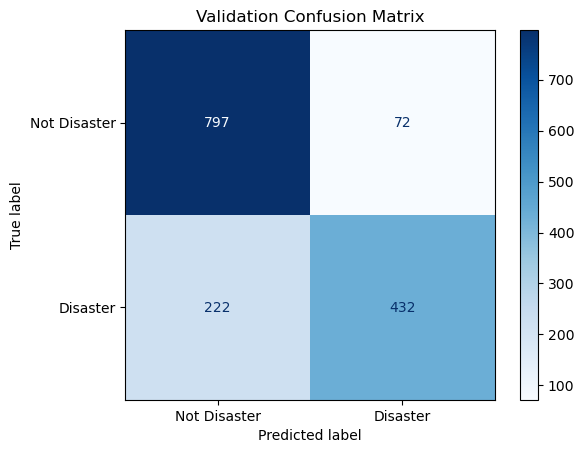

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.title('Accuracy & AUC')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()

y_val_pred_prob = model.predict(X_val)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)
print(classification_report(y_val, y_val_pred, target_names=['Not Disaster','Disaster']))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm, display_labels=['Not Disaster','Disaster']).plot(cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.show()

### **Conclusion**
#### In this mini-project, we:

* ##### Explored and cleaned tweet data

* ##### Built an embedding + BiLSTM classifier with dropout

* ##### Addressed class imbalance via weighting

#### Next improvements might include:

* ##### Fine-tuning a pretrained transformer

* ##### Data augmentation or external embeddings

* ##### Hyperparameter search

### Github Repo
#### Link:

### **Submission**

In [28]:
model.load_weights('best_model.h5')

test_ds = tf.data.Dataset.from_tensor_slices(x_test_pad).batch(BATCH_SIZE)

y_test_prob = model.predict(test_ds)
y_test_pred = (y_test_prob > 0.5).astype(int).flatten()

submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = y_test_pred
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")

102/102 [==============================] - 2s 20ms/step
Saved submission.csv
